In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os
import matplotlib.pylab as pl

from art.attacks import FastGradientMethod
from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers.pytorch import PyTorchClassifier
from art.utils import load_cifar10

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=128)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single =  DataLoader(test_dataset, batch_size=1)

In [27]:
epsilons = [0.000001, 0.001, .025, .05, .1, .15, .2, .25, .3]
path = Path("C:/Users/Matach/OneDrive - Imperial College London/ICL/FYP/Experiments/saved_models/CIFAR10/FGSM Adversarial/scenario_mix")
file = "mix_B(2).pth"
pretrained_model = os.path.join(path, file)
use_cuda = True

## Model

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
    
    activations_fc2, activations_fc1, activations_conv = [], [], []
    mask_fc2, mask_fc1, mask_conv = torch.zeros(1, 512), torch.zeros(1, 1024), torch.zeros(4096)
        

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    def forwardDetect(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        self.activations_conv.append(x)
        x = F.relu(self.fc1(x))
        self.activations_fc1.append(x)
        x = F.relu(self.fc2(x))
        self.activations_fc2.append(x)
        x = self.fc3(x)
        return x
    
    def forwardMask(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)*self.mask_conv
        x = F.relu(self.fc1(x))*self.mask_fc1
        x = F.relu(self.fc2(x))*self.mask_fc2
        x = self.fc3(x)
        return x
    
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Model().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Model(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dr

## MaskModel

In [12]:
class MaskModel(nn.Module):
    def __init__(self):
        super(MaskModel, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
    
    mask_fc2, mask_fc1, mask_conv = torch.ones(1, 512), torch.ones(1, 1024), torch.ones(4096)
        
    
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)*self.mask_conv.to(device)
        x = F.relu(self.fc1(x))*self.mask_fc1.to(device)
        x = F.relu(self.fc2(x))*self.mask_fc2.to(device)
        x = self.fc3(x)
        return x
    
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
mask_model = MaskModel().to(device)

# Load pre-trained model
mask_model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(mask_model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mask_model.parameters(), lr=0.01, momentum=0.5)

# Make a classifier wrapper!
mask_classifier = PyTorchClassifier(
    model=mask_model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
MaskModel(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout)

## Pruning

In [13]:
model.eval() 
with torch.no_grad():
    for data, target in test_dataloader_single:
        output = model.forwardDetect(data.to(device))

activations_fc2 = model.activations_fc2
activations_fc1 = model.activations_fc1
activations_conv = model.activations_conv

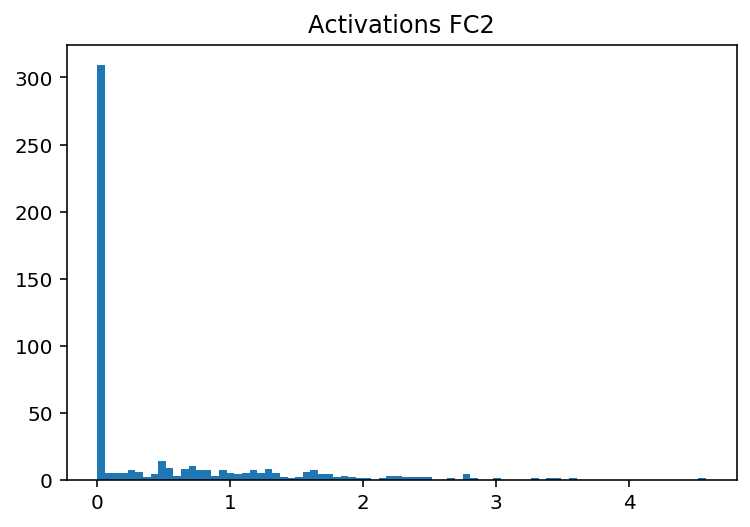

In [14]:
n = len(activations_fc2)
element0 = activations_fc2.pop()
act = torch.zeros(n,element0.size(0),element0.size(1))
act[0,:,:] = element0

for e in range(n-1):
    elementX = activations_fc2.pop()
    act[e+1,:,:] = elementX

mean_activations_fc2 = torch.mean(act,dim=[0,1])
ma = mean_activations_fc2.numpy()
plt.hist(ma,80)
plt.title('Activations FC2')
plt.show()

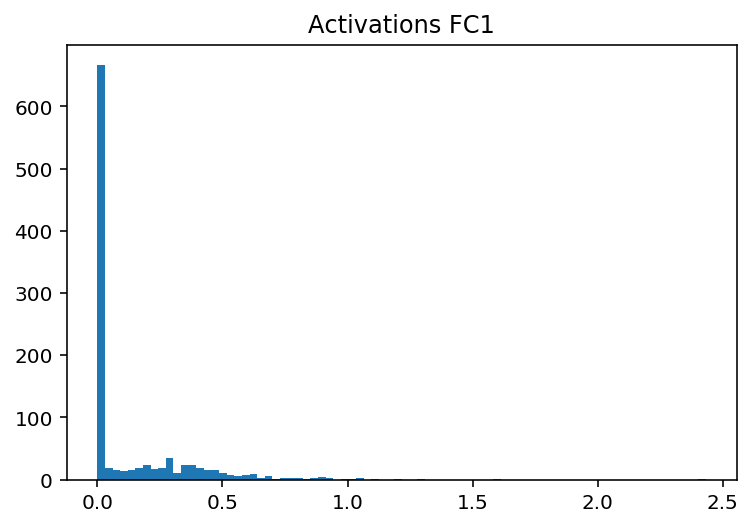

In [15]:
n = len(activations_fc1)
element0 = activations_fc1.pop()
act = torch.zeros(n,element0.size(0),element0.size(1))
act[0,:,:] = element0

for e in range(n-1):
    elementX = activations_fc1.pop()
    act[e+1,:,:] = elementX

mean_activations_fc1 = torch.mean(act,dim=[0,1])
ma = mean_activations_fc1.numpy()
plt.hist(ma,80)
plt.title('Activations FC1')
plt.show()

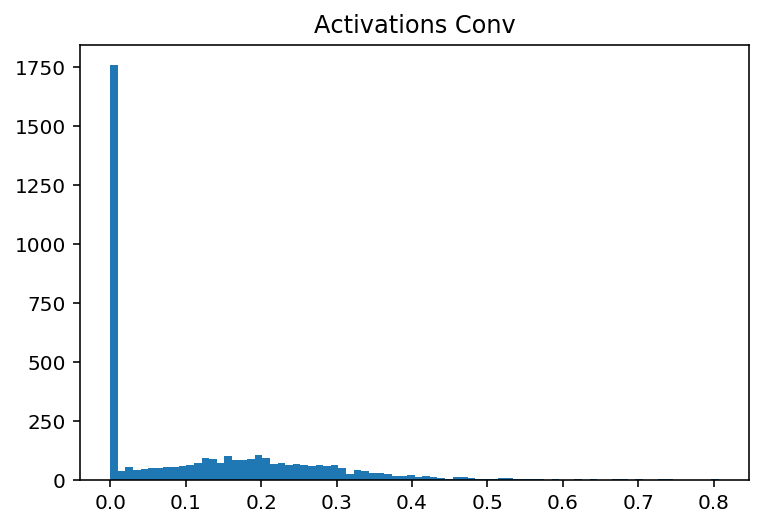

In [16]:
n = len(activations_conv)
element0 = activations_conv.pop()
act = torch.zeros(n,element0.size(0),element0.size(1))
act[0,:,:] = element0

for e in range(n-1):
    elementX = activations_conv.pop()
    act[e+1,:,:] = elementX

mean_activations_conv = torch.mean(act,dim=[0,1])
ma = mean_activations_conv.numpy()
plt.hist(ma,80)
plt.title('Activations Conv')
plt.show()

In [46]:
# save different masks for different percentages

masks_fc2 = dict()
masks_fc1 = dict()
masks_conv = dict()

for percentage in range(10):
# for percentage in [0, 4, 5, 6, 7, 8, 9]:
#     FC2
    s_ma_fc2, idx_ma_fc2 = torch.sort(mean_activations_fc2)
    m_fc2 = torch.ones(mean_activations_fc2.size()).to(device)
    nn_fc2 = mean_activations_fc2.size(0)
    ind_r_fc2 = round((percentage/10)*nn_fc2)
    m_fc2[idx_ma_fc2[:ind_r_fc2]] = 0.0
    n1_fc2 = m_fc2.sum()
    model.mask_fc2 = m_fc2
    masks_fc2[percentage/10] = model.mask_fc2
    
#     FC1
    s_ma_fc1, idx_ma_fc1 = torch.sort(mean_activations_fc1)
    m_fc1 = torch.ones(mean_activations_fc1.size()).to(device)
    nn_fc1 = mean_activations_fc1.size(0)
    ind_r_fc1 = round((percentage/10)*nn_fc1)
    m_fc1[idx_ma_fc1[:ind_r_fc1]] = 0.0
    n1_fc1 = m_fc1.sum()
    model.mask_fc1 = m_fc1
    masks_fc1[percentage/10] = model.mask_fc1


#     Conv
    s_ma_conv, idx_ma_conv = torch.sort(mean_activations_conv)
    m_conv = torch.ones(mean_activations_conv.size()).to(device)
    nn_conv = mean_activations_conv.size(0)
    ind_r_conv = round((percentage/10)*nn_conv)
    m_conv[idx_ma_conv[:ind_r_conv]] = 0.0
    n1_conv = m_conv.sum()
    model.mask_conv = m_conv
    masks_conv[percentage/10] = model.mask_conv

In [18]:
# evaluate with the new masks
acc = []
for (pg, mask_fc2), (pg, mask_fc1), (pg, mask_conv) in zip(masks_fc2.items(), masks_fc1.items(), masks_conv.items()):
    model.mask_fc2 = mask_fc2
    model.mask_fc1 = mask_fc1
    model.mask_conv = mask_conv
    
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader_single:
            output = model.forwardMask(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_dataloader_single.dataset))
        acc.append(acc_test)

    print("Pruned {}  Accuracy: {} %".format(pg, 100*acc_test))

Pruned 0.0  Accuracy: 71.63000000000001 %
Pruned 0.1  Accuracy: 71.63000000000001 %
Pruned 0.2  Accuracy: 71.63000000000001 %
Pruned 0.3  Accuracy: 71.63000000000001 %
Pruned 0.4  Accuracy: 71.63000000000001 %
Pruned 0.5  Accuracy: 71.59 %
Pruned 0.6  Accuracy: 71.17999999999999 %
Pruned 0.7  Accuracy: 69.1 %
Pruned 0.8  Accuracy: 61.660000000000004 %
Pruned 0.9  Accuracy: 43.93 %


## FGSM attack

In [25]:
masks_conv.keys()

dict_keys([0.0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [28]:
fgsm_prune = dict()
k = 5000
# Run test for each epsilon and mask PG 
for (pg, mask_fc2), (pg, mask_fc1), (pg, mask_conv) in zip(masks_fc2.items(), masks_fc1.items(), masks_conv.items()):
    print('\n Pruned {}'.format(pg))
    accuracies = []
    results = dict()
    
    mask_model.mask_fc2 = mask_fc2
    mask_model.mask_fc1 = mask_fc1
    mask_model.mask_conv = mask_conv
    
    for e in epsilons:
        adv_crafter = FastGradientMethod(mask_classifier, eps=e)
        x_test_adv = adv_crafter.generate(x=x_test[:k])
        predictions = mask_classifier.predict(x_test_adv)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:k], axis=1)) / k
        accuracies.append(accuracy)
        print("Epsilon: {}   Test Accuracy = {}".format(e, accuracy))

    results['accuracies'] = accuracies
    results['epsilons'] = epsilons
    fgsm_prune[pg] = results


 Pruned 0.0
Epsilon: 1e-06   Test Accuracy = 0.7162
Epsilon: 0.001   Test Accuracy = 0.688
Epsilon: 0.025   Test Accuracy = 0.6252
Epsilon: 0.05   Test Accuracy = 0.7074
Epsilon: 0.1   Test Accuracy = 0.7152
Epsilon: 0.15   Test Accuracy = 0.7018
Epsilon: 0.2   Test Accuracy = 0.686
Epsilon: 0.25   Test Accuracy = 0.647
Epsilon: 0.3   Test Accuracy = 0.6048

 Pruned 0.4
Epsilon: 1e-06   Test Accuracy = 0.7162
Epsilon: 0.001   Test Accuracy = 0.6882
Epsilon: 0.025   Test Accuracy = 0.6248
Epsilon: 0.05   Test Accuracy = 0.7072
Epsilon: 0.1   Test Accuracy = 0.7152
Epsilon: 0.15   Test Accuracy = 0.7018
Epsilon: 0.2   Test Accuracy = 0.6862
Epsilon: 0.25   Test Accuracy = 0.647
Epsilon: 0.3   Test Accuracy = 0.6048

 Pruned 0.5
Epsilon: 1e-06   Test Accuracy = 0.7188
Epsilon: 0.001   Test Accuracy = 0.6822
Epsilon: 0.025   Test Accuracy = 0.622
Epsilon: 0.05   Test Accuracy = 0.7082
Epsilon: 0.1   Test Accuracy = 0.7158
Epsilon: 0.15   Test Accuracy = 0.7038
Epsilon: 0.2   Test Accuracy

In [38]:
fgsm_prune_ = fgsm_prune.items()

In [40]:
fgsm_prune_s = sorted(fgsm_prune_)

In [44]:
fgsm_prune_s

[(0.0,
  {'accuracies': [0.7162,
    0.688,
    0.6252,
    0.7074,
    0.7152,
    0.7018,
    0.686,
    0.647,
    0.6048],
   'epsilons': [1e-06, 0.001, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}),
 (0.1,
  {'accuracies': [0.7162,
    0.688,
    0.6252,
    0.7074,
    0.7152,
    0.7018,
    0.686,
    0.647,
    0.6048],
   'epsilons': [1e-06, 0.001, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}),
 (0.2,
  {'accuracies': [0.7162,
    0.688,
    0.6252,
    0.7074,
    0.7152,
    0.7018,
    0.686,
    0.647,
    0.6048],
   'epsilons': [1e-06, 0.001, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}),
 (0.3,
  {'accuracies': [0.7162,
    0.688,
    0.6252,
    0.7074,
    0.7152,
    0.7018,
    0.686,
    0.647,
    0.6048],
   'epsilons': [1e-06, 0.001, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}),
 (0.4,
  {'accuracies': [0.7162,
    0.6882,
    0.6248,
    0.7072,
    0.7152,
    0.7018,
    0.6862,
    0.647,
    0.6048],
   'epsilons': [1e-06, 0.001, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]})

# Carlini attack

In [45]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)
    return x_test_adv

def CarliniLInf(classifier, x_test, epsilon):
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    samples_changed = 0
    for test, adv_test in zip(x_test, x_test_adv):
        l2 = np.linalg.norm(test-adv_test)
        dist += l2
        samples_changed = samples_changed + 1 if l2>0 else samples_changed
    dist /= samples_changed
    return dist

In [52]:
carlini_prune = dict()
constants = [0.001, 0.01, 0.025, 0.05, 0.1]
n = 1000

# Run test for each c and mask PG 
for (pg, mask_fc2), (pg, mask_fc1), (pg, mask_conv) in zip(masks_fc2.items(), masks_fc1.items(), masks_conv.items()):
    print('\n Pruned {}'.format(pg))
    accuracies, distances = [], []
    results = dict()
    
    mask_model.mask_fc2 = mask_fc2
    mask_model.mask_fc1 = mask_fc1
    mask_model.mask_conv = mask_conv
    
    for init in constants:
        x_test_adv = CarliniL2(mask_classifier, x_test[:n], init_const=init)
        predictions = mask_classifier.predict(x_test_adv)
        acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
        accuracies.append(acc)
        distances.append(L2distance(x_test[:n], x_test_adv))
        
        print('c:', init, ' Accuracy:', acc, ' Distance:', round(distances[-1], 3))

    results['accuracies'] = accuracies
    results['distances'] = distances
    results['constants'] = constants
    carlini_prune[pg] = results


 Pruned 0.0
c: 0.001  Accuracy: 0.648  Distance: 0.022
c: 0.01  Accuracy: 0.311  Distance: 0.082
c: 0.025  Accuracy: 0.201  Distance: 0.115
c: 0.05  Accuracy: 0.162  Distance: 0.14
c: 0.1  Accuracy: 0.149  Distance: 0.169

 Pruned 0.1
c: 0.001  Accuracy: 0.648  Distance: 0.022
c: 0.01  Accuracy: 0.311  Distance: 0.082
c: 0.025  Accuracy: 0.201  Distance: 0.115
c: 0.05  Accuracy: 0.162  Distance: 0.14
c: 0.1  Accuracy: 0.149  Distance: 0.169

 Pruned 0.2
c: 0.001  Accuracy: 0.648  Distance: 0.022
c: 0.01  Accuracy: 0.311  Distance: 0.082
c: 0.025  Accuracy: 0.201  Distance: 0.115
c: 0.05  Accuracy: 0.162  Distance: 0.14
c: 0.1  Accuracy: 0.149  Distance: 0.169

 Pruned 0.3
c: 0.001  Accuracy: 0.648  Distance: 0.022
c: 0.01  Accuracy: 0.311  Distance: 0.082
c: 0.025  Accuracy: 0.201  Distance: 0.115
c: 0.05  Accuracy: 0.162  Distance: 0.14
c: 0.1  Accuracy: 0.149  Distance: 0.169

 Pruned 0.4
c: 0.001  Accuracy: 0.648  Distance: 0.022
c: 0.01  Accuracy: 0.312  Distance: 0.082
c: 0.025  

In [53]:
carlini_inf_prune = dict()
epsilons = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]
n = 1000
# Run test for each c and mask PG 
for (pg, mask_fc2), (pg, mask_fc1), (pg, mask_conv) in zip(masks_fc2.items(), masks_fc1.items(), masks_conv.items()):
    print('\n Pruned {}'.format(pg))
    accuracies = []
    results = dict()
    
    mask_model.mask_fc2 = mask_fc2
    mask_model.mask_fc1 = mask_fc1
    mask_model.mask_conv = mask_conv
    
    for eps in epsilons:
        x_test_adv = CarliniLInf(mask_classifier, x_test[:n], epsilon=eps)
        predictions = mask_classifier.predict(x_test_adv)
        acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
        accuracies.append(acc)
        
        print('eps:', eps, ' Accuracy:', acc)

    results['accuracies'] = accuracies
    results['epsilons'] = epsilons
    carlini_inf_prune[pg] = results


 Pruned 0.0
eps: 0.001  Accuracy: 0.674
eps: 0.002  Accuracy: 0.605
eps: 0.003  Accuracy: 0.56
eps: 0.004  Accuracy: 0.493
eps: 0.005  Accuracy: 0.419
eps: 0.006  Accuracy: 0.357

 Pruned 0.1
eps: 0.001  Accuracy: 0.674
eps: 0.002  Accuracy: 0.605
eps: 0.003  Accuracy: 0.56
eps: 0.004  Accuracy: 0.493
eps: 0.005  Accuracy: 0.419
eps: 0.006  Accuracy: 0.357

 Pruned 0.2
eps: 0.001  Accuracy: 0.674
eps: 0.002  Accuracy: 0.605
eps: 0.003  Accuracy: 0.56
eps: 0.004  Accuracy: 0.493
eps: 0.005  Accuracy: 0.419
eps: 0.006  Accuracy: 0.357

 Pruned 0.3
eps: 0.001  Accuracy: 0.674
eps: 0.002  Accuracy: 0.605
eps: 0.003  Accuracy: 0.56
eps: 0.004  Accuracy: 0.493
eps: 0.005  Accuracy: 0.419
eps: 0.006  Accuracy: 0.357

 Pruned 0.4
eps: 0.001  Accuracy: 0.674
eps: 0.002  Accuracy: 0.605
eps: 0.003  Accuracy: 0.56
eps: 0.004  Accuracy: 0.493
eps: 0.005  Accuracy: 0.419
eps: 0.006  Accuracy: 0.357

 Pruned 0.5
eps: 0.001  Accuracy: 0.673
eps: 0.002  Accuracy: 0.611
eps: 0.003  Accuracy: 0.555
eps

In [54]:
carlini_prune

{0.0: {'accuracies': [0.648, 0.311, 0.201, 0.162, 0.149],
  'distances': [0.022361310408377473,
   0.08198942622974047,
   0.11467142045790553,
   0.1401915209325082,
   0.169160331051204],
  'constants': [0.001, 0.01, 0.025, 0.05, 0.1]},
 0.1: {'accuracies': [0.648, 0.311, 0.201, 0.162, 0.149],
  'distances': [0.022361310397355904,
   0.08198991970043412,
   0.11467188924022031,
   0.14019197246714282,
   0.1691595680176779],
  'constants': [0.001, 0.01, 0.025, 0.05, 0.1]},
 0.2: {'accuracies': [0.648, 0.311, 0.201, 0.162, 0.149],
  'distances': [0.022361310419399042,
   0.08198991968100776,
   0.11467186614062848,
   0.14019194827187956,
   0.16915954426048568],
  'constants': [0.001, 0.01, 0.025, 0.05, 0.1]},
 0.3: {'accuracies': [0.648, 0.311, 0.201, 0.162, 0.149],
  'distances': [0.022361316005956793,
   0.08199669002588164,
   0.11469658795478445,
   0.14020100331856167,
   0.16913255019456788],
  'constants': [0.001, 0.01, 0.025, 0.05, 0.1]},
 0.4: {'accuracies': [0.648, 0.312, 

In [55]:
carlini_inf_prune

{0.0: {'accuracies': [0.674, 0.605, 0.56, 0.493, 0.419, 0.357],
  'epsilons': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]},
 0.1: {'accuracies': [0.674, 0.605, 0.56, 0.493, 0.419, 0.357],
  'epsilons': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]},
 0.2: {'accuracies': [0.674, 0.605, 0.56, 0.493, 0.419, 0.357],
  'epsilons': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]},
 0.3: {'accuracies': [0.674, 0.605, 0.56, 0.493, 0.419, 0.357],
  'epsilons': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]},
 0.4: {'accuracies': [0.674, 0.605, 0.56, 0.493, 0.419, 0.357],
  'epsilons': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]},
 0.5: {'accuracies': [0.673, 0.611, 0.555, 0.484, 0.421, 0.363],
  'epsilons': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]},
 0.6: {'accuracies': [0.671, 0.602, 0.54, 0.485, 0.425, 0.367],
  'epsilons': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]},
 0.7: {'accuracies': [0.662, 0.593, 0.526, 0.468, 0.402, 0.357],
  'epsilons': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]},
 0.8: {'accura

## Results

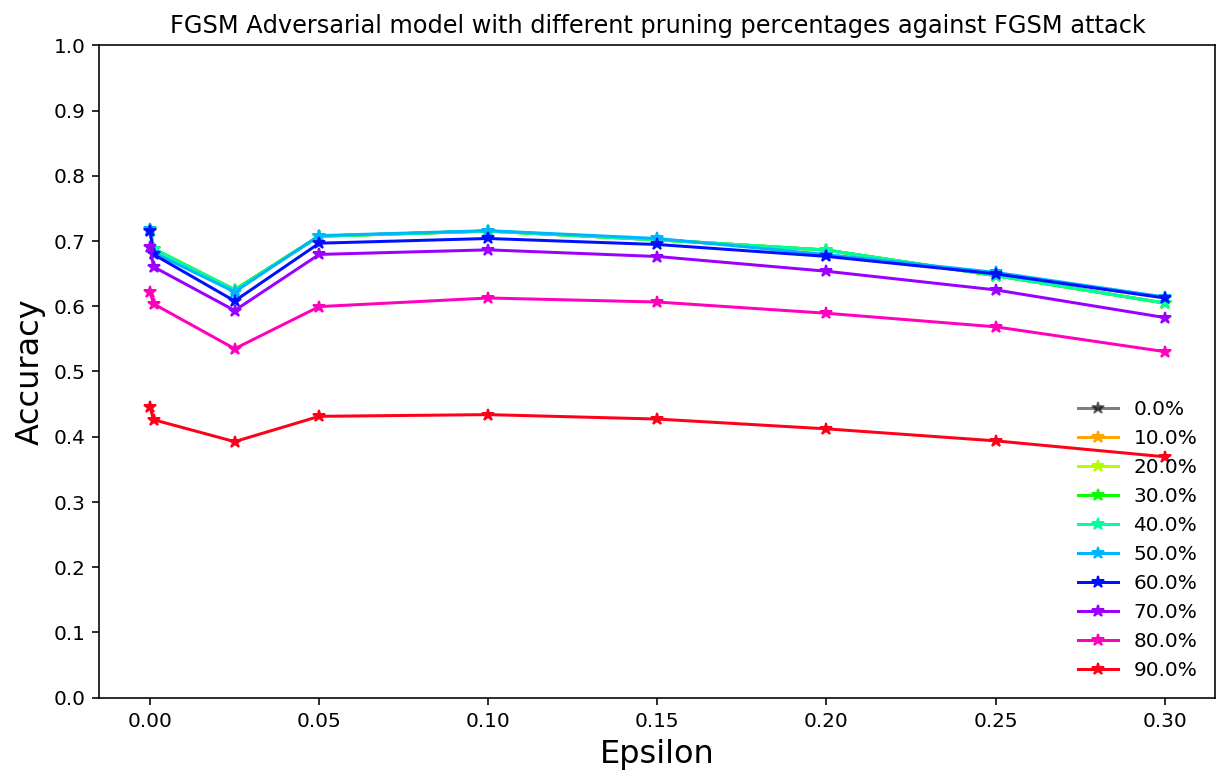

In [42]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))

# colors
n = len(fgsm_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,0.5] #half-black

for idx, (pg, results) in enumerate(fgsm_prune_s):
    plt.plot(epsilons, results['accuracies'], "*-", color=colors[idx], label=str(pg*100)+'%')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("FGSM Adversarial model with different pruning percentages against FGSM attack")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

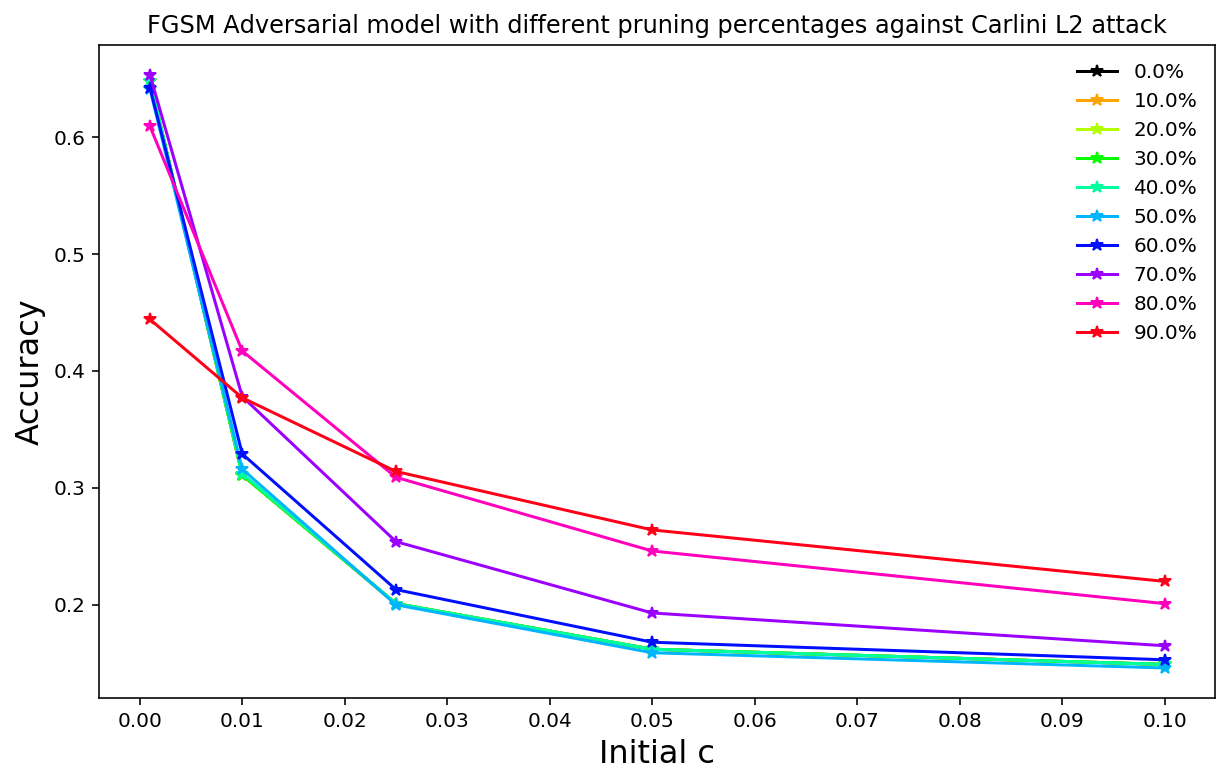

In [57]:
# plot the pruned accuracies vs initial c

plt.figure(figsize=(10,6))

# colors
n = len(carlini_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,1] 

for idx, (pg, results) in enumerate(carlini_prune.items()):
    plt.plot(results['constants'], results['accuracies'], "*-", color=colors[idx], label=str(pg*100)+'%')

# plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.11, step=0.01))
plt.title("FGSM Adversarial model with different pruning percentages against Carlini L2 attack")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

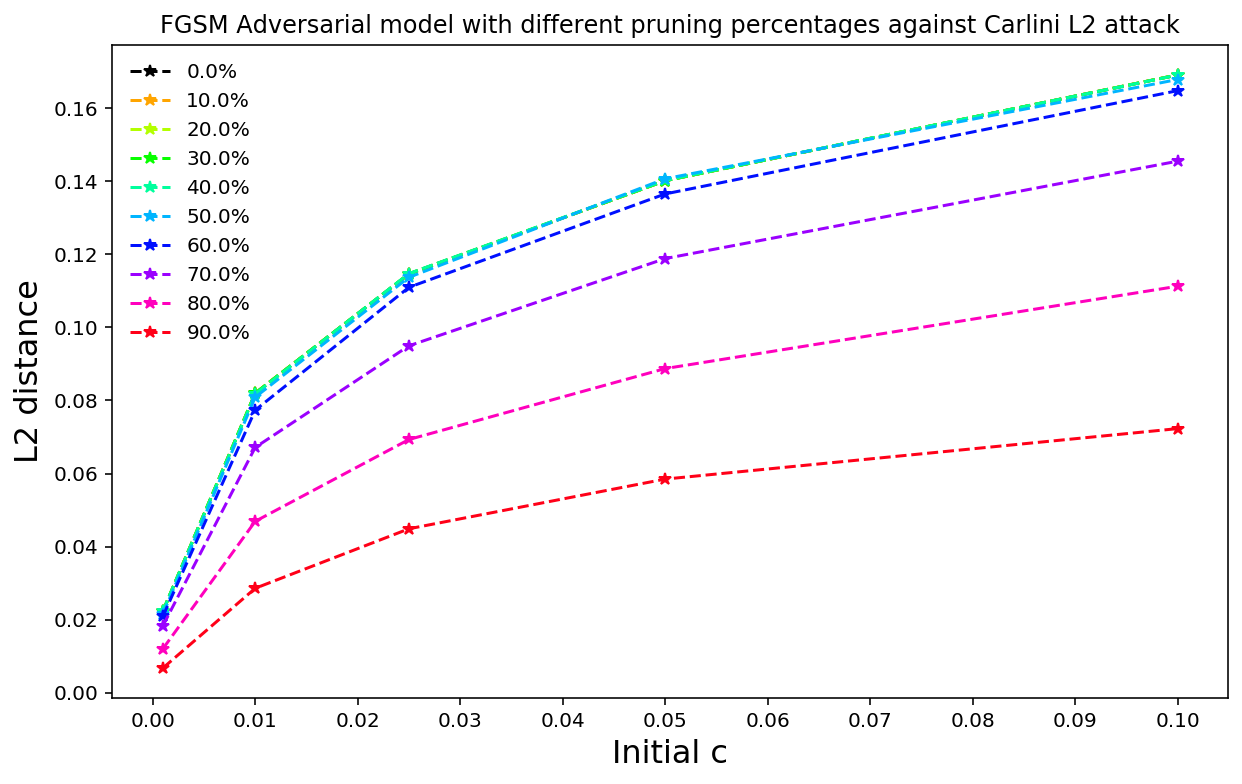

In [60]:
# plot the pruned accuracies vs initial c

plt.figure(figsize=(10,6))
# colors
n = len(carlini_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,1] 

for idx, (pg, results) in enumerate(carlini_prune.items()):
    plt.plot(results['constants'], results['distances'], "*--", color=colors[idx], label=str(pg*100)+'%')

# plt.yticks(np.arange(0, 3.6, step=0.5))
plt.xticks(np.arange(0, 0.11, step=0.01))
plt.title("FGSM Adversarial model with different pruning percentages against Carlini L2 attack")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

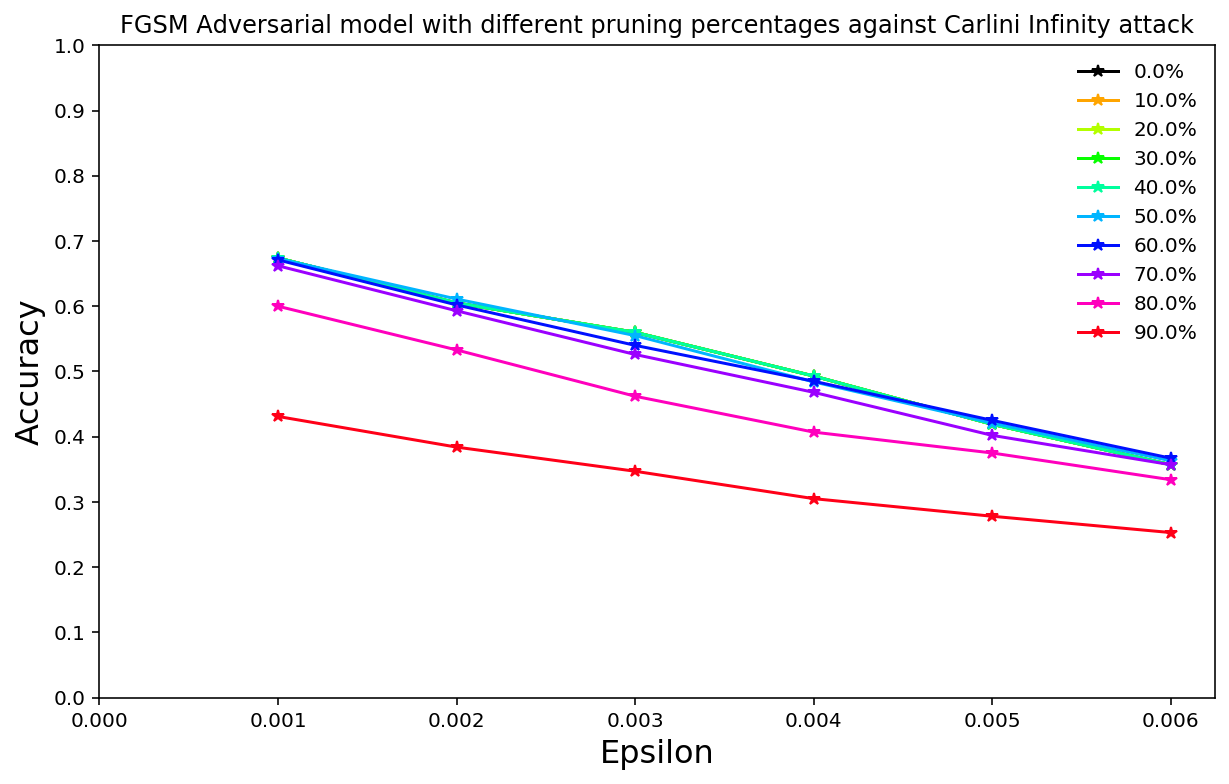

In [61]:
# plot the pruned accuracies vs initial c

plt.figure(figsize=(10,6))
# colors
n = len(carlini_inf_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,1] 

for idx, (pg, results) in enumerate(carlini_inf_prune.items()):
    plt.plot(results['epsilons'], results['accuracies'], "*-", color=colors[idx], label=str(pg*100)+'%')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.0061, step=0.001))
plt.title("FGSM Adversarial model with different pruning percentages against Carlini Infinity attack")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()